In [1]:
%matplotlib inline
'''This code loads the Fillipazo and Photometry tables and plots data after running a principle component analysis'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PCA_adjustColumns import adjustFili, adjustPhoto
from PCA_merge import merge
from PCA_calc import calc_distance, calc_dm
#from PCA_index import index
from PCA_remName import remName
from sklearn.preprocessing import Imputer, StandardScaler
from PCA_scale import scale
from PCA import perform
from PCA_plot import plot_PCA
from PCA_vectors import vectors
from PCA_color import colorColumns
from PCA_RMSE import RMSE
from sklearn.pipeline import make_pipeline

/Users/Owner/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#load Fili Table
fili = pd.read_csv('Fili15 Table9.csv', delimiter=',')
#load Photometry Table
photo = pd.read_csv('photometry_198.csv', delimiter=',')

#adjust tables 
newfili=adjustFili(fili)
newphoto=adjustPhoto(photo)

#merge tables into one table without duplicate columns
fiPh=merge(newfili, newphoto)

#calculate distance
distance=calc_distance(fiPh)

#return table with distance modulus accounted for  
dm=calc_dm(distance)

newcolumns=newphoto.columns.tolist()
for elem in newcolumns:
    if elem=='shortname':
        continue
    fiPh[elem]=fiPh[elem]-dm

#remove shortname and age columns
newfiPh=remName(fiPh)

#remove rows where Temperature, Luminosity=NaN
newfiPh=newfiPh[np.isfinite(newfiPh['Temperature'])]
newfiPh=newfiPh[np.isfinite(newfiPh['Luminosity'])]

In [3]:
#create color columns
BDdict = {'J' : 1.24, 'H' : 1.66, 'K' : 2.19, 'Ks' : 2.16, 'W1' : 3.35, 'W2' : 4.6, 'W3' : 11.56, 'W4' : 22.09, '[3.6]' : 3.51, '[4.5]' : 4.44, '[5.8]' : 5.63, '[8]' : 7.59, 'g' : .48, 'i' : .76, 'r' : .62, 'u' : .35, 'z' : .91 }
newfiPh=colorColumns(newfiPh, BDdict)

In [4]:
#impute TRAIN data
imp=Imputer(strategy="mean")
imp.fit(newfiPh)
data_imputed=imp.transform(newfiPh)
data_imputed=pd.DataFrame(data_imputed,columns=newfiPh.columns.tolist())

In [5]:
from sklearn.cross_validation import train_test_split
train, test=train_test_split(data_imputed, test_size = 0.2)

In [6]:
#scale TRAIN data
scaler=StandardScaler()
scaler.fit(train.loc[:,'H':])
data_scaled=pd.DataFrame(scaler.transform(train.loc[:,'H':]),columns=train.loc[:,'H':].columns.tolist())


In [7]:
#fit PCA (data_scaled, # of components)
pca=perform(data_scaled, .8)

In [8]:
#transform PCA
data_PCA=pd.DataFrame(pca.transform(data_scaled))

In [9]:
loadings=pd.DataFrame(pca.components_,columns=data_scaled.columns.tolist())
loadings_sq=loadings**2
loadings_sq=loadings_sq.transpose()

In [10]:
x0=data_PCA[0].reshape(-1, 1)

ytemp=train.Temperature.reshape(-1, 1)
ylum=train.Luminosity.reshape(-1, 1)
ygrav=train.Gravity.reshape(-1, 1)

In [11]:
from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(degree=2)
#x_=poly.fit_transform(x)
from sklearn.linear_model import LinearRegression
#lr = LinearRegression()
#lr.fit(x_,y)

modeltemp=make_pipeline(PolynomialFeatures(2),LinearRegression())
modeltemp.fit(x0,ytemp)

modellum=make_pipeline(PolynomialFeatures(2),LinearRegression())
modellum.fit(x0,ylum)

modelgrav=make_pipeline(PolynomialFeatures(2),LinearRegression())
modelgrav.fit(x0,ygrav)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [12]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [13]:
#scale TEST data
test_scaled=pd.DataFrame(scaler.transform(test.loc[:,'H':]),columns=test.loc[:,'H':].columns.tolist())


In [14]:
#transform PCA
test_PCA=pd.DataFrame(pca.transform(test_scaled))

In [15]:
x02=test_PCA[0].reshape(-1, 1)
ytemp2=test.Temperature.reshape(-1, 1)
ylum2=test.Luminosity.reshape(-1, 1)
ygrav2=test.Gravity.reshape(-1, 1)

#lr.transform(x2)

test_rmse_temp=RMSE(ytemp2, modeltemp.predict(x02))
test_rmse_lum=RMSE(ylum2, modellum.predict(x02))
test_rmse_grav=RMSE(ygrav2, modelgrav.predict(x02))

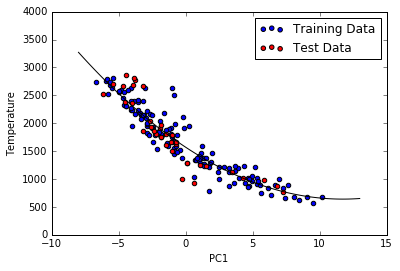

In [16]:
x3=np.linspace(-8,13,100)
xnew=x3[:,np.newaxis]
plt.scatter(data_PCA[0], train.Temperature, label='Training Data')
plt.scatter(test_PCA[0], test.Temperature, c='red', label='Test Data')
plt.plot(xnew, modeltemp.predict(xnew), c='black')
plt.xlabel('PC1')
plt.ylabel('Temperature')
plt.ylim(0,4000)
plt.legend(loc='best')
#plt.savefig('/Users/Owner/Summer_Research/graphs/KEEP_NaN_P1_T.png')
plt.show()

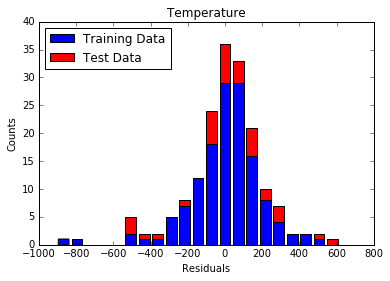

In [17]:
ypred=modeltemp.predict(x0).reshape(-1,1)
ydata=train.Temperature.reshape(-1,1)
residuals=ypred-ydata        

ypred2=modeltemp.predict(x02)
ydata2=test.Temperature.reshape(-1,1)
residuals2=ypred2-ydata2   

n,bins,_ = plt.hist([residuals, residuals2], color = ['blue', 'red'], label=['Training Data','Test Data'], bins=21, stacked=True)

plt.xlabel('Residuals')
plt.ylabel('Counts')
plt.legend(loc='best')
plt.title('Temperature')
#plt.savefig('/Users/Owner/Summer_Research/graphs/KEEP_NaN_Res_hist_P1_T.png')
plt.show()

In [18]:
test_rmse_temp

258.61542488930132

In [19]:
#SECOND PC

x1=data_PCA[1].reshape(-1, 1)

modeltemp1=make_pipeline(PolynomialFeatures(2),LinearRegression())
modeltemp1.fit(x1,ytemp)

modellum1=make_pipeline(PolynomialFeatures(2),LinearRegression())
modellum1.fit(x1,ylum)

modelgrav1=make_pipeline(PolynomialFeatures(2),LinearRegression())
modelgrav1.fit(x1,ygrav)

x12=test_PCA[1].reshape(-1, 1)

test_rmse_temp1=RMSE(ytemp2, modeltemp1.predict(x12))
test_rmse_lum1=RMSE(ylum2, modellum1.predict(x12))
test_rmse_grav1=RMSE(ygrav2, modelgrav1.predict(x12))

In [20]:
#THIRD PC

x2=data_PCA[2].reshape(-1, 1)

modeltemp2=make_pipeline(PolynomialFeatures(2),LinearRegression())
modeltemp2.fit(x2,ytemp)

modellum2=make_pipeline(PolynomialFeatures(2),LinearRegression())
modellum2.fit(x2,ylum)

modelgrav2=make_pipeline(PolynomialFeatures(2),LinearRegression())
modelgrav2.fit(x2,ygrav)

x22=test_PCA[2].reshape(-1, 1)

test_rmse_temp2=RMSE(ytemp2, modeltemp2.predict(x22))
test_rmse_lum2=RMSE(ylum2, modellum2.predict(x22))
test_rmse_grav2=RMSE(ygrav2, modelgrav2.predict(x22))

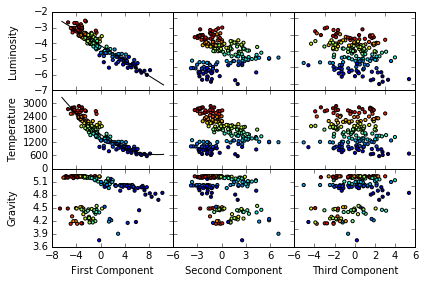

In [30]:
from matplotlib.ticker import MaxNLocator

axes = [plt.subplot(3,3,i+1) for i in range(9)]

for ax in range(6):
    axes[ax].set_xticklabels([])

for ax in [1,2,4,5,7,8]:
    axes[ax].set_yticklabels([])

for ax in range(1,8):    
    ybins=len(axes[ax].get_xticklabels())
    axes[ax].yaxis.set_major_locator(MaxNLocator(nbins=ybins, prune='upper'))
    xbins=len(axes[ax].get_yticklabels())
    axes[ax].xaxis.set_major_locator(MaxNLocator(nbins=xbins, prune='upper'))
    
    
axes[0].set_ylabel('Luminosity', labelpad=15) 
axes[3].set_ylabel('Temperature')
axes[6].set_ylabel('Gravity', labelpad=15)
axes[6].set_xlabel('First Component') 
axes[7].set_xlabel('Second Component')
axes[8].set_xlabel('Third Component')

train_color=train.Temperature
test_color=test.Temperature

axes[0].scatter(data_PCA[0], train.Luminosity, c=train_color, label='Training Data', s=10)
axes[0].scatter(test_PCA[0], test.Luminosity, c=test_color, label='Test Data', s=10)
modellum=LinearRegression().fit(x0, ylum)
axes[0].plot(xnew, modellum.predict(xnew), c='black')

axes[1].scatter(data_PCA[1], train.Luminosity, c=train_color, label='Training Data', s=10)
axes[1].scatter(test_PCA[1], test.Luminosity, c=test_color, label='Test Data', s=10)
# axes[1].plot(xnew, modellum1.predict(xnew), c='black')

axes[2].scatter(data_PCA[2], train.Luminosity, c=train_color, label='Training Data', s=10)
axes[2].scatter(test_PCA[2], test.Luminosity, c=test_color, label='Test Data', s=10)
# axes[2].plot(xnew, modellum2.predict(xnew), c='black')

axes[3].scatter(data_PCA[0], train.Temperature, c=train_color, label='Training Data', s=10)
axes[3].scatter(test_PCA[0], test.Temperature, c=test_color, label='Test Data', s=10)
axes[3].plot(xnew, modeltemp.predict(xnew), c='black')

axes[4].scatter(data_PCA[1], train.Temperature, c=train_color, label='Training Data', s=10)
axes[4].scatter(test_PCA[1], test.Temperature, c=test_color, label='Test Data', s=10)
# axes[4].plot(xnew, modeltemp1.predict(xnew), c='black')

axes[5].scatter(data_PCA[2], train.Temperature, c=train_color, label='Training Data', s=10)
axes[5].scatter(test_PCA[2], test.Temperature, c=test_color, label='Test Data', s=10)
# axes[5].plot(xnew, modeltemp2.predict(xnew), c='black')

axes[6].scatter(data_PCA[0], train.Gravity, c=train_color, label='Training Data', s=10)
axes[6].scatter(test_PCA[0], test.Gravity, c=test_color, label='Test Data', s=10)
# axes[6].plot(xnew, modelgrav.predict(xnew), c='black')

axes[7].scatter(data_PCA[1], train.Gravity, c=train_color, label='Training Data', s=10)
axes[7].scatter(test_PCA[1], test.Gravity, c=test_color, label='Test Data', s=10)
# axes[7].plot(xnew, modelgrav1.predict(xnew), c='black')

axes[8].scatter(data_PCA[2], train.Gravity, c=train_color, label='Training Data', s=10)
axes[8].scatter(test_PCA[2], test.Gravity, c=test_color, label='Test Data', s=10)
# axes[8].plot(xnew, modelgrav2.predict(xnew), c='black')


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('/Users/Owner/Summer_Research/graphs/KEEP_TLG123.png', dpi=150)
#plt.show()

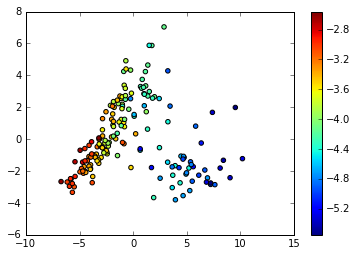

In [36]:
plt.scatter(data_PCA[0], data_PCA[1], c=train.Luminosity)
plt.scatter(test_PCA[0], test_PCA[1], c=test.Luminosity)
plt.colorbar()

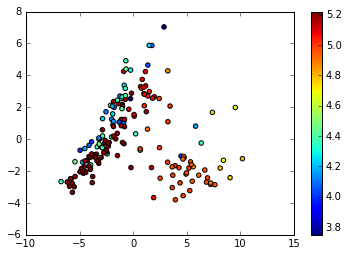

In [37]:
plt.scatter(data_PCA[0], data_PCA[1], c=train.Gravity)
plt.scatter(test_PCA[0], test_PCA[1], c=test.Gravity)
plt.colorbar()
plt.show()

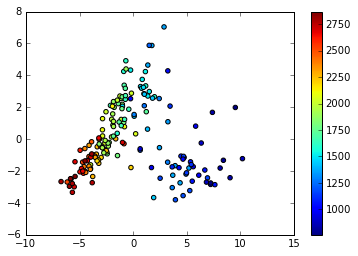

In [38]:
plt.scatter(data_PCA[0], data_PCA[1], c=train.Temperature)
plt.scatter(test_PCA[0], test_PCA[1], c=test.Temperature)
plt.colorbar()

In [25]:

# Plot each slice as an independent subplot
#fig, axes = plt.subplots(nrows=3, ncols=3)
fig, axes = [plt.subplots(3,3, sharex=True, sharey=True)

    # The vmin and vmax arguments specify the color limits
im = ax.imshow(ygrav)
cax = fig.add_axes([.95, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cax)

plt.show()

SyntaxError: invalid syntax (<ipython-input-25-b7282cd7c17c>, line 7)

In [ ]:

my_image2 = ygrav
plt.imshow(my_image2, aspect='auto')
plt.colorbar()

In [ ]:
help(plt.colorbar)

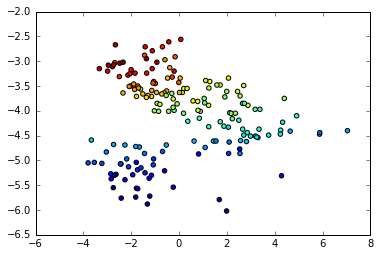

In [34]:
plt.scatter(data_PCA[1], train.Luminosity, c=train_color, label='Training Data')
plt.scatter(test_PCA[1], test.Luminosity, c=test_color, label='Test Data')
plt.show()